<a href="https://colab.research.google.com/github/CamelGoong/DataScienceLab/blob/main/%5B%EB%B0%95%ED%95%B4%EA%B7%A0%5D210819_CNN2_%EC%84%B8%EC%85%98%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn #많은 neural network이 담겨있는 모듈입니다. 
import torch.optim as optim  # 많은 optimizer가 담겨있는 모듈입니다. 
import torch.nn.init as init # neural network를 초기화 하는 모듈을 담고 있습니다. 
from torch.utils.data import DataLoader # DataLoader는 데이터를 batch_size만큼 불러오는 역할 등을 수행합니다. 
import torchvision 
import torchvision.datasets as dset # 사진 등의 vision 데이터가 담겨있는 모듈입니다. 
import torchvision.transforms as transforms #이 모듈에는 데이터를 자르고, 반전시키고 tensor로 변환해주기 등의 데이터 변환 함수가 담겨있습니다.
import numpy as np
import os 
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
print(torch.__version__)


1.9.0+cu102


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -qq "/content/gdrive/MyDrive/DSL/20210819_CNN1/archive.zip" -d "/content/gdrive/MyDrive/DSL/20210819_CNN/"

In [3]:
path = '/content/gdrive/MyDrive/DSL/20210819_CNN/chest_xray'
mean = torch.tensor([0.4822])
std = torch.tensor([0.2328])
transformations = transforms.Compose([transforms.Resize((64,64)), 
                              transforms.ToTensor(), 
                              transforms.Normalize(mean, std),
                             ])

In [67]:
train = ImageFolder(os.path.join(path, 'train'), transform=transformations, target_transform=lambda x:np.reshape(np.float32(x),(-1,1)))
val = ImageFolder(os.path.join(path, 'val'), transform=transformations, target_transform=lambda x:np.reshape(np.float32(x),(-1.1)))
test = ImageFolder(os.path.join(path, 'test'), transform=transformations)

In [68]:
print(train.__getitem__(0)[0].size(), train.__len__())
print(test.__getitem__(0)[0].size(), test.__len__())

print(len(train),len(test))
#print(mnist_train[0])


torch.Size([3, 64, 64]) 5216
torch.Size([3, 64, 64]) 624
5216 624


In [69]:
num_epoch=16
batch_size=326
learning_rate= 0.0003

In [70]:
#데이터 쪼개기
train_loader=DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=DataLoader(dataset=test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

In [75]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5, padding=2), # [batch_size,3,64,64] -> [batch_size,16,64,64]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                              # [batch_size,16,64,64] -> [batch_size,16,32,32]
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5, padding=2),# [batch_size,16,32,32] -> [batch_size,32,32,32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                              # [batch_size,32,32,32] -> [batch_size,32,16,16]
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5, padding=2),# [batch_size,32,16,16] -> [batch_size,64,16,16]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                               # [batch_size,64,16,16] -> [batch_size,64,8,8]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*8*8,1000),                                            # [batch_size,64*13*13] -> [batch_size,1000]
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 100),                                                # [batch_size,1000] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100, 10),   
            nn.Linear(10,1),                                         # [batch_size,100] -> [batch_size,10]
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        out = torch.sigmoid(out)
        return out

In [78]:
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model=CNN().to(device)
criterion = torch.nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=0.1)

In [79]:
loss_arr=[]
for i in range(num_epoch):
  for image,label in train_loader:
    x = image.to(device)
    y = label.view(-1,1)
    y = y.to(torch.float32)
    y = y.to(device)
    optimizer.zero_grad()
    prob = model(x)

    loss = criterion(prob, y)
    # loss = loss_func(output, y_)     
    #loss = loss_func(output, torch.max(y_, 1)[1])

    loss.backward()
    optimizer.step()    
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

tensor(0.6701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6609, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6633, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6611, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6534, devic

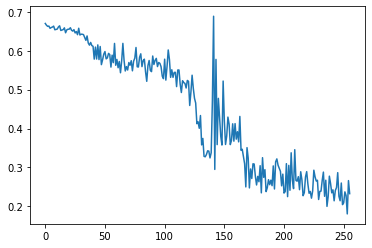

In [80]:
plt.plot(loss_arr)
plt.show()

In [81]:
correct=0
total=0

with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)
    output=model.forward(x)
    _,output_index=torch.max(output,1)
    total+=label.size(0)
    correct += (output_index==y_).sum().float()

print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 71.77913665771484%
